# TP3 IIA

## Integrantes

* Juan Ignacio García (a2008)
* Rodrigo Mesa Marchi (a2016)
* Danilo Simón Reitano Andrades (a2020)

### Tareas y preguntas a resolver

1. ¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM? ¿Hay palabras en común? ¿Algunas llaman la atención?
1. Separe el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba (70% y 30% respectivamente).
1. Utilizando un clasificador de Bayes ingenuo, entrene con el conjunto de entrenamiento.
1. Utilizando un clasificador de Regresión Logística, entrene con el conjunto de entrenamiento (en este caso, normalice los datos).
1. Calcule la matriz de confusión del conjunto de evaluación para ambos modelos. ¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?
1. Calcule la precisión y la recuperación de ambos modelos. Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.
1. Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn nos ofrece una variedad ampliada de modelos Naive Bayes, para este problema usamos MultinomialNB que es pensado para este tipo de problemas
from sklearn.naive_bayes import MultinomialNB   

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve

In [2]:
dataset = pd.read_csv("spambase.csv") # cargando los datos desde un CSV
dataset.head(10)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
5,0,0,0,0,1850,0,0,1850,0,0,...,0,0,0,0,223,0,0,0,0,1
6,0,0,0,0,1920,0,0,0,0,640,...,0,0,0,0,54,0,164,54,0,1
7,0,0,0,0,1880,0,0,1880,0,0,...,0,0,0,0,206,0,0,0,0,1
8,150,0,460,0,610,0,300,0,920,760,...,0,0,0,0,271,0,181,203,22,1
9,60,120,770,0,190,320,380,0,60,0,...,0,0,0,40,30,0,244,81,0,1


In [3]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()

In [4]:
df = column_sum.melt("spam").copy()#[dataset["spam"]==0].sort_values("value").head(10)
df["word"] = df["variable"].str.replace("word_freq_","").str.replace("char_freq_","")
df = df.drop(columns=["variable"],axis=0)

¿Cuáles son las 10 palabras más encontradas en correos con SPAM y en correos No SPAM?

In [5]:
df_max_normal = df[df["spam"]==0].sort_values("value",ascending=False).head(10).copy()
df_max_normal

,spam,value,word
36,0,3541702,you
52,0,3527559,george
48,0,2496576,hp
22,0,1495268,will
40,0,1223098,your
50,0,1204398,hpl
88,0,1159138,re
90,0,800669,edu
2,0,681569,address
82,0,604460,meeting


In [6]:
df_max_spam = df[df["spam"]==1].sort_values("value",ascending=False).head(10).copy()
df_max_spam

,spam,value,word
37,1,4105599,you
41,1,2502597,your
23,1,997100,will
31,1,939790,free
9,1,931799,our
103,1,931352,!
5,1,732080,all
19,1,635470,mail
35,1,578759,email
33,1,521250,business


In [7]:
s1 = pd.merge(df_max_normal, df_max_spam, how='inner', on=['word'])

¿Hay palabras en común? ¿Algunas llaman la atención?

In [8]:
s1

,spam_x,value_x,word,spam_y,value_y
0,0,3541702,you,1,4105599
1,0,1495268,will,1,997100
2,0,1223098,your,1,2502597


Las palabras que se repiten son las siguientes:
- you: si bien aparece en ambos casos, aparece más en casos de spam.
- will: si bien aparece en ambos casos, aparece más en casos de correos verídicos.
- your: si bien aparece en ambos casos, aparece mucho más en casos de spam.

Algunas palabras que llaman la atención son:
- free: aparece mucho en casos de spam y puede indicar que hay un ofrecimiento de algo gratuito que sea una estafa.
- business: aparece mucho en casos de spam y puede indicar que hay un ofrecimiento de algo relacionado a negocios que sea una estafa.

In [9]:
# Obtenemos los atributos y target
X = (dataset.drop(columns="spam") * 100).astype(int)
#X = dataset2.drop(columns="spam")
y = dataset["spam"]

In [10]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3)

#### NaibeBayes

In [11]:
nb_regressor = MultinomialNB(alpha = 1)

nb_regressor.fit(X_train, y_train)

MultinomialNB(alpha=1)

#### Logistical Regression

In [12]:
numerical_columns = X_train.columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num",MinMaxScaler(), numerical_columns)
    ]
)



pipe = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("regressor",LogisticRegression())



    ]
)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_...
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',
       'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!',
       'char_freq_$', 'char_freq_#'],
      dtype='object'))])),
                ('regressor', LogisticRegression())])

In [13]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_...
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',
       'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!',
       'char_freq_$', 'char_freq_#'],
      dtype='object'))])),
                ('regressor', LogisticRegression())])

In [14]:
y_pred_nb = nb_regressor.predict(X_test)
y_pred_lr = pipe.predict(X_test)

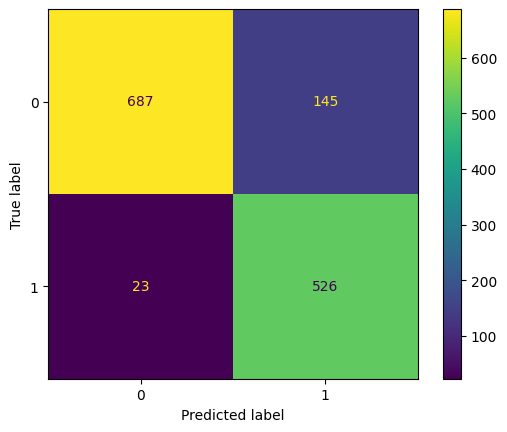

In [15]:
ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred_nb)).plot()

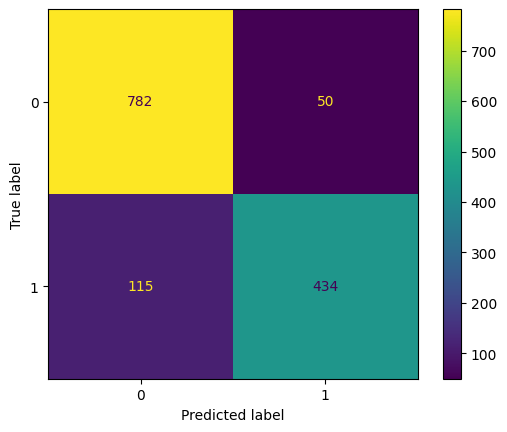

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_true=y_test, y_pred=y_pred_lr)).plot()

¿Qué tipo de error comete más cada modelo? ¿Cuál de los dos tipos de error crees que es más importante para este problema?

El clasificador de Bayes ingenuo comete más errores de tipo 1 (falsos positivos), mientras que el clasificador de Regresión Logística comete más errores de tipo 2 (falsos negativos). En este caso, el error de tipo 1 es más importante, ya que un falso positivo puede llevar a que un correo legítimo sea marcado como spam y no llegue al destinatario.

In [17]:
def print_scores(y_true, y_pred):
    print(f"El valor de accuracy resulta: {accuracy_score(y_true, y_pred)}")
    print(f"El valor de precision_score resulta: {precision_score(y_true, y_pred)}")
    print(f"El valor de recall_score resulta: {recall_score(y_true, y_pred)}")

#### Metricas Naibe Bayes

In [18]:
print_scores(y_test, y_pred_nb)

El valor de accuracy resulta: 0.8783490224475018
El valor de precision_score resulta: 0.7839046199701938
El valor de recall_score resulta: 0.9581056466302368


#### Metricas Logistic Regression

In [19]:
print_scores(y_test, y_pred_lr)

El valor de accuracy resulta: 0.8805213613323678
El valor de precision_score resulta: 0.8966942148760331
El valor de recall_score resulta: 0.7905282331511839


Para cada métrica, ¿cuál es el mejor modelo? ¿Cómo se relacionan estas métricas con los tipos de errores analizados en el punto anterior? Expanda su respuesta.

La precisión y la recuperación son métricas que se utilizan para evaluar el rendimiento de un modelo de clasificación. La precisión mide la proporción de verdaderos positivos entre todos los positivos predichos, mientras que la recuperación mide la proporción de verdaderos positivos entre todos los positivos reales. El accuracy mide la proporción de verdaderos positivos y verdaderos negativos entre todos los casos.

En este caso, el clasificador de Bayes ingenuo tiene una precisión del 0.78 y una recuperación del 0.96, mientras que el clasificador de Regresión Logística tiene una precisión del 0.90 y una recuperación del 0.79.
Esto significa que el clasificador de Bayes ingenuo es menos preciso, pero más sensible a los correos spam, mientras que el clasificador de Regresión Logística es más preciso, pero menos sensible a los correos spam.

Si tuvieramos que elegir un modelo, teniendo en cuenta que lo más importante es no perdernos ningún correo legítimo elegiríamos el clasificador de regresión logística, ya que tiene más precisión y menos falsos positivos. Sin embargo, si lo que queremos es detectar la mayor cantidad de correos spam, elegiríamos el clasificador de Bayes ingenuo, ya que tiene más recuperación y menos falsos negativos.

### ROC

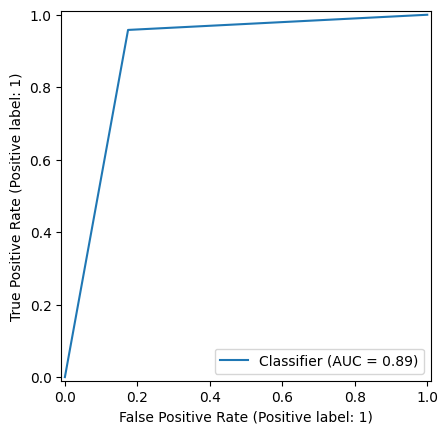

In [20]:
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_pred_nb)

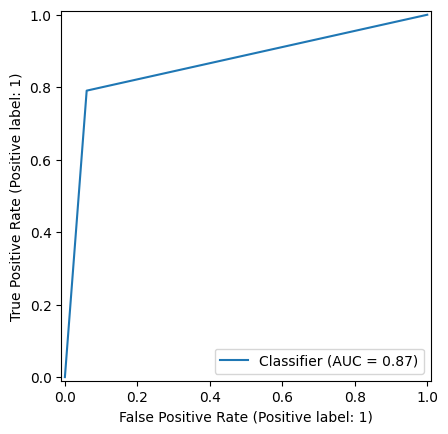

In [21]:
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=y_pred_lr)

Analizando las curvas de ROC y su área bajo la curva (AUC), podemos ver que el clasificador de Bayes ingenuo tiene un AUC de 0.89, mientras que el clasificador de Regresión Logística tiene un AUC de 0.87. Esto significa que el clasificador de Bayes ingenuo tiene un mejor rendimiento en términos de sensibilidad y especificidad, lo que indica que es más efectivo para detectar correos spam y legítimos. Sin embargo, ambos modelos tienen un buen rendimiento en general, ya que ambos AUC son mayores a 0.8.

Viendo la curva y teniendo en cuenta nuevamente que lo más importante es no perdernos ningún correo legítimo, elegiríamos el clasificador de Regresión Logística, ya que con un rate de falsos positivos de al rededor de 0.07, el rate de verdaderos positivos es de 0.8, mientras que el clasificador de Bayes ingenuo tiene un rate de falsos positivos de al rededor de 0.2 y un rate de verdaderos positivos de 0.95.